Question 6 (a)

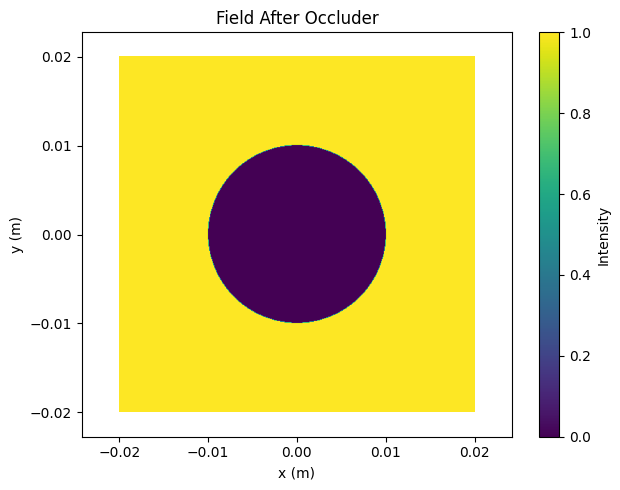

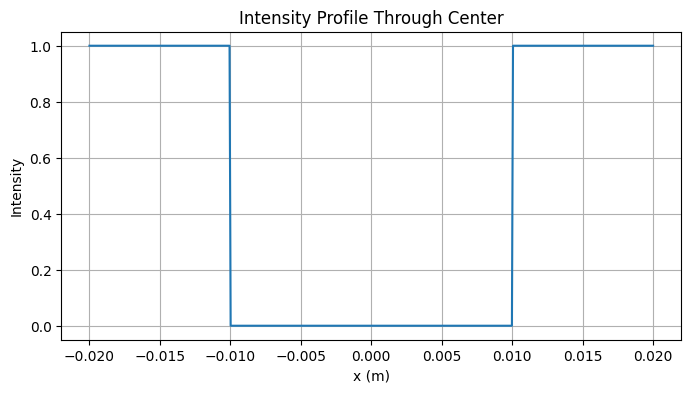

Central intensity: 0.000
Maximum intensity: 1.000


In [20]:
import numpy as np
import matplotlib.pyplot as plt

def propagate_field(field, dx, wavelength, z):
    """Propagate field using angular spectrum method."""
    N = field.shape[0]
    
    fx = np.fft.fftfreq(N, dx)
    fy = np.fft.fftfreq(N, dx)
    FX, FY = np.meshgrid(fx, fy)
    
    return angular_spectrum_propagation(field, FX, FY, wavelength, z)

def angular_spectrum_propagation(field, fx, fy, wavelength, z):
    """Apply angular spectrum propagation transfer function."""
    k = 2 * np.pi / wavelength
    kx = 2 * np.pi * fx
    ky = 2 * np.pi * fy
    kz = np.sqrt(k**2 - kx**2 - ky**2)
    
    H = np.exp(1j * kz * z)
    H[np.iscomplex(kz)] = 0
    
    U0 = np.fft.fft2(field)
    U0 = np.fft.fftshift(U0)
    U1 = U0 * H
    U1 = np.fft.ifftshift(U1)
    return np.fft.ifft2(U1)

def simulate_poisson_spot():
    wavelength = 633e-9  # meters (633 nm)
    D = 0.02  # meters (2 cm)
    xmax = 0.02  # meters (2 cm)
    N = 512

    dx = 2 * xmax / N
    x = np.linspace(-xmax, xmax, N)
    y = np.linspace(-xmax, xmax, N)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)

    mask = np.ones((N, N))
    mask[R < D/2] = 0
    incident_field = np.ones((N, N))
    field_after = incident_field * mask


    return x, field_after

def plot_results(x, intensity):
    """Plot the simulation results in SI units (meters)."""
    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.imshow(intensity, extent=[x[0], x[-1], x[0], x[-1]])
    plt.colorbar(label='Intensity')
    plt.title(f'Field After Occluder')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.axis('equal')

    plt.tight_layout()
    
    plt.figure(figsize=(8, 4))
    center_idx = len(x) // 2
    plt.plot(x, intensity[center_idx, :])
    plt.title('Intensity Profile Through Center')
    plt.xlabel('x (m)')
    plt.ylabel('Intensity')
    plt.grid(True)
    
    plt.show()

    center_idx = len(x) // 2
    print(f"Central intensity: {intensity[center_idx, center_idx]:.3f}")
    print(f"Maximum intensity: {np.max(intensity):.3f}")

if __name__ == "__main__":
    x, field_after = simulate_poisson_spot()
    plot_results(x, field_after)

Question 6 （B）

Padding: 512 pixels = 0.040000 m per side
Padded field size: 0.120000 m x 0.120000 m
Padded field max magnitude at z = 5 m: 1.380942
Cropped field max magnitude at z = 5 m: 1.380942
Unpadded initial field max magnitude at z = 0 m: 1.000000
Padded initial field max magnitude at z = 0 m: 1.000000+0.000000j


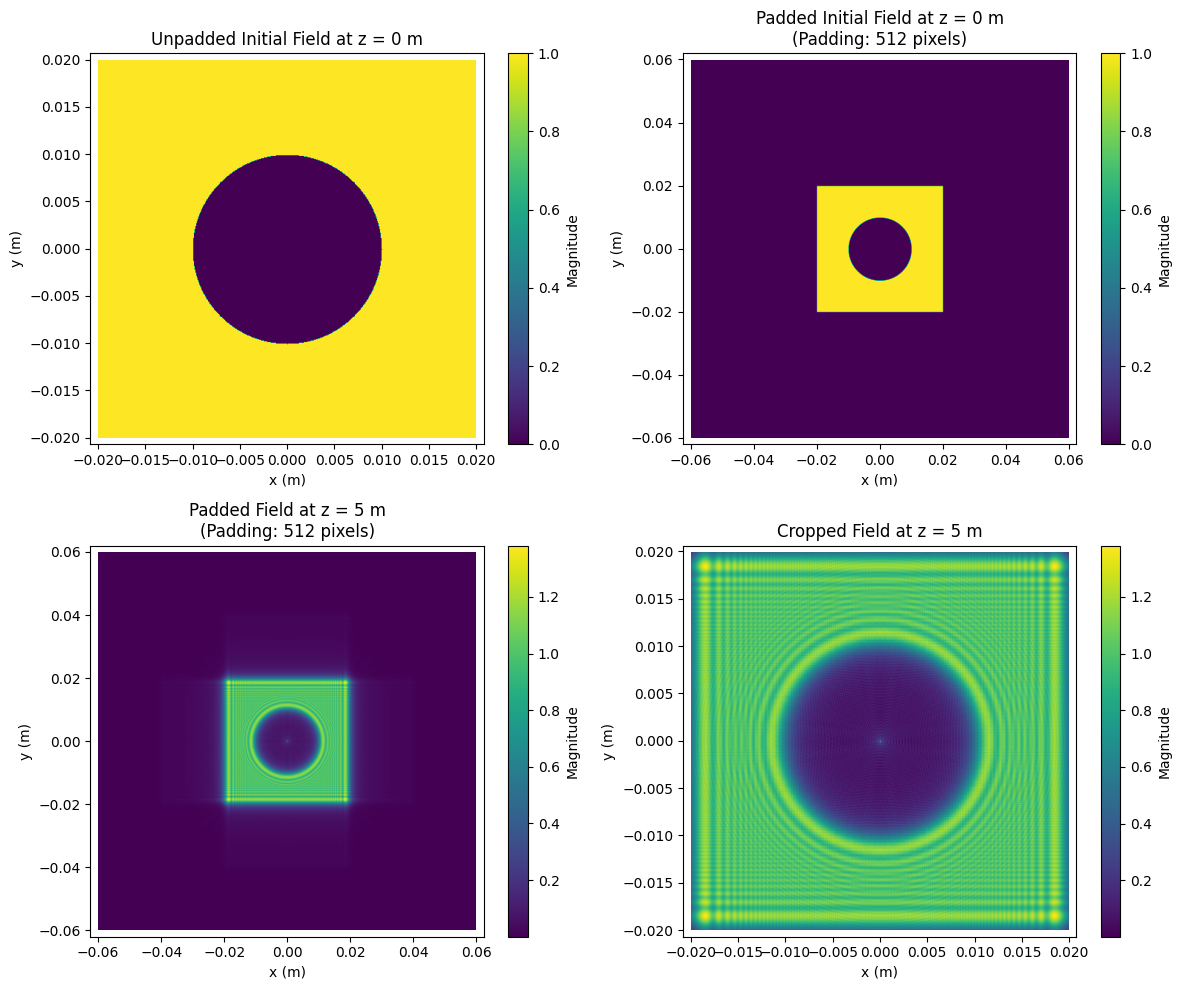

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def angular_spectrum_propagation(E0, wavelength, z, xmax, N, padding_pixels=0):
    """Calculate electric field propagation with optional padding, returning both padded and cropped fields"""
    # Handle padding
    if padding_pixels > 0:
        N_padded = N + 2 * padding_pixels
        E0_padded = np.zeros((N_padded, N_padded), dtype=complex)
        start_idx = padding_pixels
        end_idx = padding_pixels + N
        E0_padded[start_idx:end_idx, start_idx:end_idx] = E0
        input_field = E0_padded
        total_N = N_padded
        total_xmax = xmax * (N_padded / N)
    else:
        input_field = E0
        total_N = N
        total_xmax = xmax
    
    # Propagation setup
    dx = 2 * total_xmax / total_N
    x = np.linspace(-total_xmax, total_xmax, total_N, endpoint=False)
    X, Y = np.meshgrid(x, x)
    
    k = 2 * np.pi / wavelength
    fx = np.fft.fftfreq(total_N, dx)
    FX, FY = np.meshgrid(fx, fx)
    
    kx = 2 * np.pi * FX
    ky = 2 * np.pi * FY
    kz = np.sqrt(k**2 - kx**2 - ky**2)
    H = np.exp(1j * kz * z)
    H[np.iscomplex(kz)] = 0  # Eliminate evanescent waves
    
    U0 = np.fft.fft2(input_field)
    U = U0 * H
    E = np.fft.ifft2(U)
    mag_padded = np.abs(E)
    
    X_padded = X
    Y_padded = Y
    
    # Crop if padded
    if padding_pixels > 0:
        mag_cropped = mag_padded[start_idx:end_idx, start_idx:end_idx]
        X_cropped = X[start_idx:end_idx, start_idx:end_idx]
        Y_cropped = Y[start_idx:end_idx, start_idx:end_idx]
    else:
        mag_cropped = mag_padded
        X_cropped = X
        Y_cropped = Y
    
    return (mag_padded, X_padded, Y_padded), (mag_cropped, X_cropped, Y_cropped)

def create_initial_field(xmax, N):
    """Create initial field with circular occluder"""
    dx = 2 * xmax / N
    x = np.linspace(-xmax, xmax, N, endpoint=False)
    X, Y = np.meshgrid(x, x)
    R = np.sqrt(X**2 + Y**2)
    
    # Circular occluder (D = 0.02 m)
    D = 0.02
    mask = np.ones((N, N))
    mask[R < D/2] = 0
    return np.ones((N, N)) * mask

def pad_initial_field(E0, N, padding_pixels):
    """Pad the initial field with zeros"""
    if padding_pixels > 0:
        N_padded = N + 2 * padding_pixels
        E0_padded = np.zeros((N_padded, N_padded), dtype=complex)
        start_idx = padding_pixels
        end_idx = padding_pixels + N
        E0_padded[start_idx:end_idx, start_idx:end_idx] = E0
        dx = 2 * (N_padded / N) * (0.02 / N)  # Adjust for new domain size
        x_padded = np.linspace(-0.02 * (N_padded / N), 0.02 * (N_padded / N), N_padded, endpoint=False)
        X_padded, Y_padded = np.meshgrid(x_padded, x_padded)
        return E0_padded, X_padded, Y_padded
    return E0, None, None  # Return original if no padding

def simulate_and_plot(padding_pixels=0):
    # Parameters (SI units)
    wavelength = 633e-9  # m
    xmax = 0.02          # m
    N = 512              # pixels per side
    z = 5                # m (changed from 0.5 m as requested)
    
    # Generate initial field
    E0 = create_initial_field(xmax, N)
    
    # Get padded and unpadded initial fields
    E0_unpadded = E0
    E0_padded, X_padded_init, Y_padded_init = pad_initial_field(E0, N, padding_pixels)
    
    # Propagate field to z = 5 m
    (mag_padded, X_padded, Y_padded), (mag_cropped, X_cropped, Y_cropped) = angular_spectrum_propagation(
        E0, wavelength, z, xmax, N, padding_pixels
    )
    
    # Print some info
    dx = 2 * xmax / N
    padding_m = padding_pixels * dx
    total_xmax_padded = xmax * ((N + 2 * padding_pixels) / N)
    print(f"Padding: {padding_pixels} pixels = {padding_m:.6f} m per side")
    print(f"Padded field size: {total_xmax_padded*2:.6f} m x {total_xmax_padded*2:.6f} m")
    print(f"Padded field max magnitude at z = {z} m: {np.max(mag_padded):.6f}")
    print(f"Cropped field max magnitude at z = {z} m: {np.max(mag_cropped):.6f}")
    print(f"Unpadded initial field max magnitude at z = 0 m: {np.max(E0_unpadded):.6f}")
    print(f"Padded initial field max magnitude at z = 0 m: {np.max(E0_padded):.6f}")
    
    # Plotting
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    # Unpadded initial field (z = 0 m)
    ax1.imshow(np.abs(E0_unpadded), extent=[-0.02, 0.02, -0.02, 0.02])
    ax1.set_title('Unpadded Initial Field at z = 0 m')
    ax1.set_xlabel('x (m)')
    ax1.set_ylabel('y (m)')
    ax1.axis('equal')
    plt.colorbar(ax1.images[0], ax=ax1, label='Magnitude')
    
    # Padded initial field (z = 0 m)
    if padding_pixels > 0:
        ax2.imshow(np.abs(E0_padded), extent=[X_padded_init[0,0], X_padded_init[0,-1], Y_padded_init[0,0], Y_padded_init[-1,0]])
    else:
        ax2.imshow(np.abs(E0_unpadded), extent=[-0.02, 0.02, -0.02, 0.02])
    ax2.set_title(f'Padded Initial Field at z = 0 m\n(Padding: {padding_pixels} pixels)')
    ax2.set_xlabel('x (m)')
    ax2.set_ylabel('y (m)')
    ax2.axis('equal')
    plt.colorbar(ax2.images[0], ax=ax2, label='Magnitude')
    
    # Padded propagated field (z = 5 m)
    ax3.imshow(mag_padded, extent=[X_padded[0,0], X_padded[0,-1], Y_padded[0,0], Y_padded[-1,0]])
    ax3.set_title(f'Padded Field at z = {z} m\n(Padding: {padding_pixels} pixels)')
    ax3.set_xlabel('x (m)')
    ax3.set_ylabel('y (m)')
    ax3.axis('equal')
    plt.colorbar(ax3.images[0], ax=ax3, label='Magnitude')
    
    # Cropped propagated field (z = 5 m)
    ax4.imshow(mag_cropped, extent=[X_cropped[0,0], X_cropped[0,-1], Y_cropped[0,0], Y_cropped[-1,0]])
    ax4.set_title(f'Cropped Field at z = {z} m')
    ax4.set_xlabel('x (m)')
    ax4.set_ylabel('y (m)')
    ax4.axis('equal')
    plt.colorbar(ax4.images[0], ax=ax4, label='Magnitude')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    padding_pixels = 256 * 2  # 512 pixels total padding (256 per side)
    simulate_and_plot(padding_pixels)

Physical Basis: The Poisson Spot (Arago Spot):
The Poisson spot, or Arago spot, is a diffraction phenomenon that occurs when light waves pass around the edges of a circular obstacle (in your case, a circular occluder with diameter D = 0.02 m). According to the wave nature of light, waves diffract (bend) around the edges of the occluder and interfere with each other in the region behind it.
In the shadow region (behind the occluder), these diffracted waves can interfere constructively at the center (directly behind the occluder), creating a bright spot. This spot is unexpected from a purely geometric optics perspective (which predicts a dark shadow), but it’s a direct consequence of wave optics and the Huygens-Fresnel principle.

Propagation Distance (z = 5 m):
At z = 0 m (immediately after the occluder), as shown in your initial field plots, there’s a dark circular region (magnitude = 0) where the occluder blocks the light, and a bright region (magnitude = 1) outside it. No bright spot exists at this point because diffraction hasn’t had time to develop.
By z = 5 m, the light has propagated far enough for diffraction effects to become significant. The angular spectrum propagation method you’re using models this diffraction, allowing edge waves to interfere constructively at the center, forming the Poisson spot. The longer propagation distance (z = 5 m compared to z = 0.5 m in earlier versions) enhances this effect, making the bright spot more pronounced.

Light waves from the edges of the circular occluder (r = 0.01 m) diffract and spread into the shadow region. These waves travel slightly different path lengths to reach the center point (x = 0, y = 0) at z = 5 m. Due to the symmetry of the circular occluder and the wavelength (λ = 633 nm), these path length differences result in constructive interference at the center, producing the bright spot.
The size and intensity of the Poisson spot depend on the wavelength, occluder size (D), and propagation distance (z). For your parameters, z = 5 m is well within the far-field regime (Fresnel number F ≈ D²/(λz) ≈ 0.02²/(633e-9 * 5) ≈ 126), where the diffraction pattern is fully developed, and the central bright spot is expected.